In [2]:
# for reasonably clean early exit from cells - use exit()
import sys
sys.path.append("..")
from ipython_exit import exit

In [3]:
# Import the library EUMDAC
import eumdac
import time
import requests
import fnmatch
import shutil

from IPython.core.display import HTML
import datetime
import xarray as xr

# Authentication

In [4]:
# Insert your personal key and secret into the single quotes

consumer_key = 'KEY'
consumer_secret = 'SECRET'

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

try:
    print(f"This token '{token}' expires {token.expiration}")
except requests.exceptions.HTTPError as exc:
    print(f"Error when trying the request to the server: '{exc}'")

data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/metop/"

This token '7ba26427-467d-37c2-bcbb-d04890a5d36a' expires 2023-06-21 09:37:05.344737


# Selecting a product from the Data Store

https://api.eumetsat.int/api-key/

In [4]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:METOP:ASCSZR1B')

In [10]:
display(HTML('<b>'+selected_collection.title+'</b>'))
display(HTML('<b>ID:</b> '+str(selected_collection)))
display(HTML('<b>Abstract:</b> '+selected_collection.abstract))

In [6]:
start = datetime.datetime(2018, 10, 30, 2, 10)
end = datetime.datetime(2018, 11, 1, 2, 10)

In [7]:
 # Set bounding-box coordinates
bbox = '-71, 40, 70, 41'

In [8]:
# Test Pioneer 10

lat = 40.1334
lon = -70.7785

location = [lon, lat]

In [9]:
from sentinelsat import geojson_to_wkt

footprint_json = {
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": location
    }
}
footprint = geojson_to_wkt(footprint_json)

products = selected_collection.search(
     #bbox=bbox,
     geo=footprint,
     dtstart=start,
     dtend=end)

In [10]:
# Select one of the products from the search in the previous cell
print(products.first())

ASCA_SZR_1B_M02_20181101003000Z_20181101021158Z_N_O_20181101021149Z


In [11]:
# Select latest product from collection
latest = selected_collection.search().first()
print(latest)

ASCA_SZR_1B_M01_20230210113000Z_20230210130858Z_N_O_20230210122717Z


In [5]:
# import dict containing metadata for in-situ data
# https://raw.githubusercontent.com/jerabaul29/MachineOcean_WP1_WHOI/main/mo_whoi_data/data_files/in_situ_dict.py
# from private repo at https://github.com/jerabaul29/MachineOcean_WP1_WHOI
import time
import os

os.environ["TZ"] = "UTC"
time.tzset()

import datetime
import pytz

utc_timezone = pytz.timezone("UTC")

wd = os.getcwd()

os.chdir("../../MachineOcean_WP1_WHOI/mo_whoi_data/data_files")

import in_situ_dict
in_situ_obs = in_situ_dict.get_in_situ_metadata()

os.chdir(wd)

print(in_situ_obs.keys())

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])


In [16]:

print(min(in_situ_obs.values(), key=lambda x: x['datetime_start']))
print(max(in_situ_obs.values(), key=lambda x: x['datetime_end']))

sorted_in_situ_obs = sorted(in_situ_obs.values(), key=lambda x: x['datetime_start'])

import pprint
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(sorted_in_situ_obs)

{'datetime_start': datetime.datetime(2004, 11, 26, 9, 11, 0, 1, tzinfo=<UTC>), 'datetime_end': datetime.datetime(2006, 1, 31, 22, 12, 24, 986109, tzinfo=<UTC>), 'type': 'whoi_buoy', 'lat': [38.318], 'lon': [-65.0], 'nc_data_location': 'received, exported from .mat'}
{'datetime_start': datetime.datetime(2020, 8, 18, 0, 12, 0, 37625, tzinfo=<UTC>), 'datetime_end': datetime.datetime(2021, 7, 31, 23, 11, 59, 960944, tzinfo=<UTC>), 'type': 'whoi_buoy', 'lat': [59.9337], 'lon': [-39.47378], 'nc_data_location': 'received, exported from .mat'}
[{'datetime_end': datetime.datetime(2006, 1, 31, 22, 12, 24, 986109, tzinfo=<UTC>),
  'datetime_start': datetime.datetime(2004, 11, 26, 9, 11, 0, 1, tzinfo=<UTC>),
  'lat': [38.318],
  'lon': [-65.0],
  'nc_data_location': 'received, exported from .mat',
  'type': 'whoi_buoy'},
 {'datetime_end': datetime.datetime(2013, 9, 30, 8, 14, 0, 4, tzinfo=<UTC>),
  'datetime_start': datetime.datetime(2012, 9, 14, 23, 9, 59, 999998, tzinfo=<UTC>),
  'lat': [24.5837

In [13]:
exit()

nproducts = 0

print("Finding products with colocations for {} in-situ observation sites.".format(len(in_situ_obs)))

for site in in_situ_obs:
    location = [in_situ_obs[site]["lon"][0], in_situ_obs[site]["lat"][0]]
    start_time = in_situ_obs[site]["datetime_start"]
    end_time = in_situ_obs[site]["datetime_end"]
    
    footprint_json = {
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": location
      }
    }
    footprint = geojson_to_wkt(footprint_json)

    print("Searching {} from {} to {}...".format(footprint, start_time, end_time))
    
    results = selected_collection.search(
      geo=footprint,
      dtstart=start_time,
      dtend=end_time)

    nproducts += len(results)

    # attach scihub products to relevant in-situ obs site
    in_situ_obs[site]["products"] = results
    
    time.sleep(1) # take it easy...

print("ASCAT sat products available: " + str(nproducts))

IpyExit: 

In [16]:
# pickle imported in-situ measurements metadata with attached colocated ASCAT sat products metadata
# (to avoid having to rerun the API search)
import pickle

exit() # do not run, unless the search in the previous cell has been run
with open('in_situ_obs_ascat.pickle', 'wb') as handle:
    pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

IpyExit: 

In [17]:
# read pickled imported in-situ measurements metadata with attached colocated ASCAT sat products metadata
# (to avoid having to rerun the API search)
import pickle

with open('in_situ_obs_ascat.pickle', 'rb') as handle:
    in_situ_obs = pickle.load(handle)

In [18]:
print(in_situ_obs.keys())
print(in_situ_obs['Pioneer_6']["products"])
print(in_situ_obs['Pioneer_6']["products"].first())

# for each in_situ_obs timeseries, collocated sat products are found as a dict in "products"
#import pprint 
#pp = pprint.PrettyPrinter(indent=4)

for product in in_situ_obs['Pioneer_6']["products"]:
    display(HTML('<b>'+str(product)+'</b>'))
    display(HTML('<b>Orbit type:</b> '+str(product.metadata['properties']['acquisitionInformation'][0]['platform']['orbitType'])))
    display(HTML('<b>Instrument:</b> '+product.instrument))
    display(HTML('<b>Satellite:</b> '+product.satellite))
    display(HTML('<b>Sensing start:</b> '+str(product.sensing_start)))
    display(HTML('<b>Sensing end:</b> '+str(product.sensing_end)))
    display(HTML('<b>Size:</b> '+str(product.size)))
    display(HTML('<b>Files:</b>'))
    for entry in product.entries:
        display(entry)
    print("----------------------------------------")
    break

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])
<class 'eumdac.collection.SearchResults'>(EO:EUM:DAT:METOP:ASCSZR1B, {'publication': None, 'dtstart': '2017-06-09T13:11:00.017529+00:00', 'set': None, 'bbox': None, 'orbit': None, 'type': None, 'sat': None, 'sort': None, 'title': None, 't6': None, 'geo': 'POINT(-70.7785 40.1334)', 'dtend': '2017-10-31T23:12:00.016778+00:00', 'zone': None})
ASCA_SZR_1B_M01_20171030150000Z_20171030163858Z_N_O_20171030155208Z


'EOPMetadata.xml'

'manifest.xml'

'ASCA_SZR_1B_M01_20171030150000Z_20171030163858Z_N_O_20171030155208Z.nat'

----------------------------------------


Endurance_8 has 170 colocations
Irminger_7 has 1853 colocations
SPURS2 has 457 colocations
Endurance_4 has 267 colocations
Irminger_6 has 872 colocations
Pioneer_5 has 344 colocations
CLIMODE has 0 colocations
Endurance_9 has 115 colocations
Pioneer_10 has 355 colocations
SouthernOcean2 has 1107 colocations
Endurance_3 has 313 colocations
Pioneer_3 has 360 colocations
SPURS1 has 245 colocations
Endurance_7 has 368 colocations
Irminger_3 has 1417 colocations
Pioneer_7 has 319 colocations
Pioneer_6 has 529 colocations
Pioneer_8 has 328 colocations
Total no of sat products: 9419


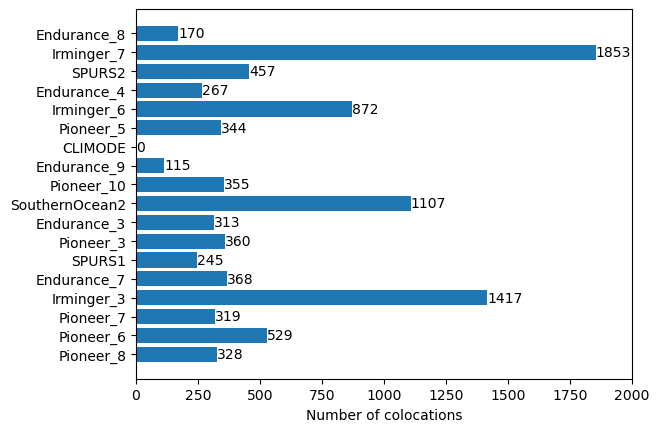

In [19]:
# how many colocations do we have? 
# (*assuming that there always are temporal colocations to be found as long as sat product is within in-situ obs start-end time interval)

sites = []
n_colocations = []
total_n_colocations = 0

for name, obs in in_situ_obs.items():
    sites.append(name)
    n = len(obs["products"])
    n_colocations.append(n)
    total_n_colocations += n
    print("{} has {} colocations".format(name, n))

print("Total no of sat products: {}".format(total_n_colocations))

# visualize
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

y_pos = np.arange(len(sites))

hbars = ax.barh(y_pos, n_colocations, align='center')
ax.set_yticks(y_pos, labels=sites)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Number of colocations")

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%i')
ax.set_xlim(right=2000)  # adjust xlim to fit labels

plt.show()

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(in_situ_obs["Pioneer_6"])

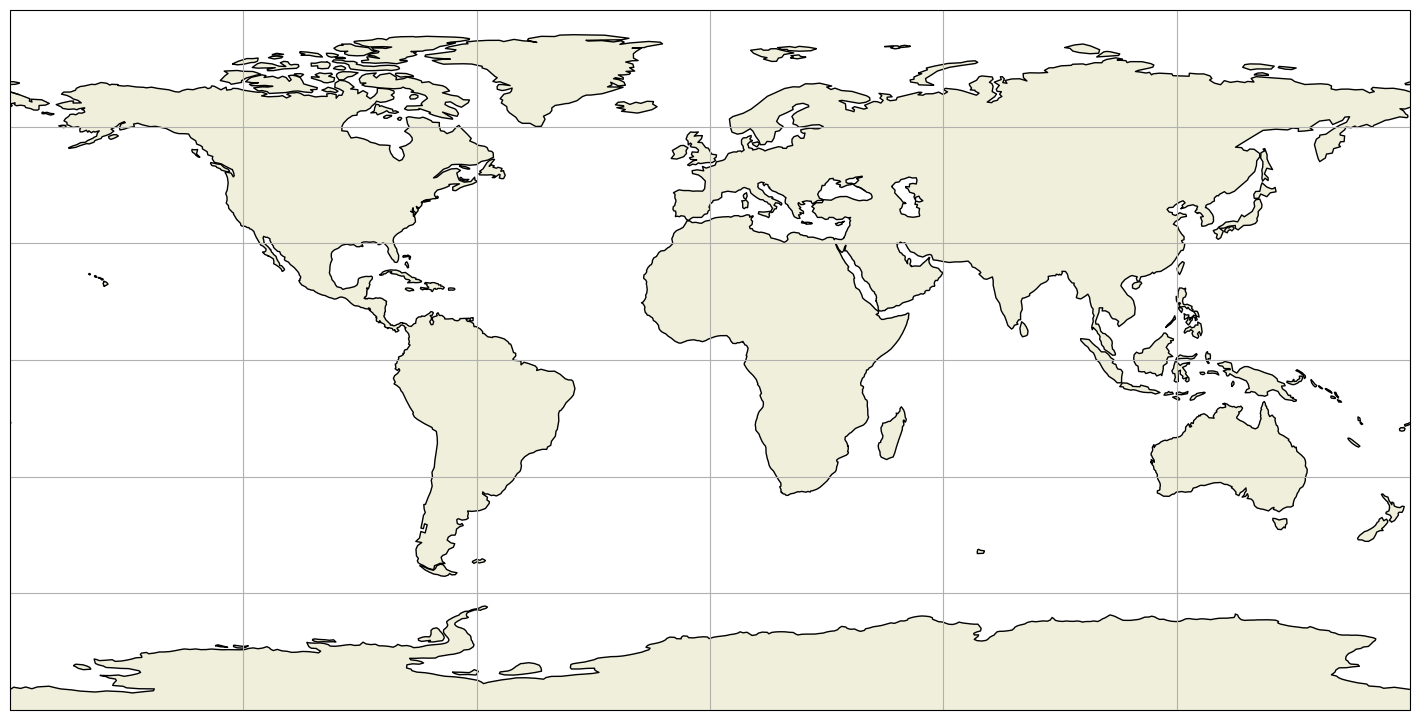

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import numpy as np

fig = plt.figure(figsize=(20, 20))

#bounds = products_gdf.total_bounds

ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
#ax1.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

#ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
#ax2.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
#ax2.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.COASTLINE)
#
#locations_np = np.array(locations)
#locs_x, locs_y = locations_np.T
#ax2.scatter(locs_x, locs_y, transform=ccrs.PlateCarree(), zorder=2)

plt.show()

# Customization

In [9]:
datatailor = eumdac.DataTailor(token)

The Data Tailor, when applying customisations, simplifies the NetCDF4 products by changing/removing some of the headers and descriptions. But it's also possible to get a non-simplified NetCDF4 by changing format='netcdf4' to format='netcdf4_satellite' in your chain.

As additional information, for the netcdf-satellite (NetCDF - Data Centre) option, the format specification for the native product is described in https://www.eumetsat.int/media/38671 and the mapping between the native and the netCDF is given in http://usc.tools.eumetsat.int/docs/changelog_netCDF_v2_0.htm

The difference between 'format: netcdf4_satellite' and 'format: netcdf4' is that you can apply one or multiple customisations on 'format: netcdf4', including the feature you want, "ROI" (Region of Interest). But it's not possible to have both the ROI feature applied and have "format: netcdf4_satellite" conversion at the same time. You can see all the customisation limitations on available products in this table (see the comments column):   

https://eumetsatspace.atlassian.net/wiki/spaces/DSDT/pages/1909096468/Products+and+Customisations+Available+in+Data+Tailor

If you want to use 'format: netcdf4' though, it's possible to apply ROI customisation in your chain. The chain should be as follows:

 

chain = eumdac.tailor_models.Chain(

     product='ASCATL1SZR',

     format='netcdf4',

     roi={"NSWE":[-0.91,-2.44,-50.17,-47.64]}

     )

In [6]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4',
     projection='geographic'
)

#chain = eumdac.tailor_models.Chain(
#     product='ASCATL1SZR',
#     format='netcdf4_satellite'
#)

In [30]:
in_situ_obs['Pioneer_6']["nc_files"] = {}

in_situ_obs['Pioneer_6']["customisations"] = []

print("Running customisations")

for product in in_situ_obs['Pioneer_6']["products"]:
    # do not process products that are already downloaded
    if str(product) in in_situ_obs['Pioneer_6']["nc_files"].keys():
        print(f"Product already processed and downloaded...skipping!")
        continue        

    customisation = datatailor.new_customisation(product, chain)

    try:
        print(f"Customisation {customisation._id} started.")
    except eumdac.datatailor.DataTailorError as error:
        print(f"Error related to the Data Tailor: '{error.msg}'")
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    in_situ_obs['Pioneer_6']["customisations"].append(customisation)
    
    status = customisation.status
    sleep_time = 10 # seconds

    # Customisation Loop
    while status:
        # Get the status of the ongoing customisation
        status = customisation.status

        if "DONE" in status:
            print(f"Customisation {customisation._id} is successfully completed.")
            break
        elif status in ["ERROR","FAILED","DELETED","KILLED","INACTIVE"]:
            print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
            print(customisation.logfile)
            break
        elif "QUEUED" in status:
            print(f"Customisation {customisation._id} is queued.")
        elif "RUNNING" in status:
            print(f"Customisation {customisation._id} is running.")
        time.sleep(sleep_time)
        
print("All customisations completed!")

Running customisations
...........all customisations completed!


# Download

In [28]:
print("Downloading products")

for customisation in in_situ_obs['Pioneer_6']["customisations"]:
    jobID= customisation._id
    print(f"\tStarting to download the NetCDF output of the customisation {jobID}")

    nc, = fnmatch.filter(customisation.outputs, '*.nc')
    try:
        with customisation.stream_output(nc,) as stream, \
                open(data_dir + stream.name, mode='wb') as fdst:
            shutil.copyfileobj(stream, fdst)
            in_situ_obs['Pioneer_6']["nc_files"][str(product)] = stream.name
        print(f"Dowloaded the output of the customisation {jobID}")
    except eumdac.datatailor.CustomisationError as error:
        print(f"Data Tailor Error", error)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        break

    try:
        customisation.delete()
    except eumdac.datatailor.CustomisationError as exc:
        print("Customisation Error:", exc)
        break
    except requests.exceptions.HTTPError as error:
        print(f"HTTP error: '{error.msg}'")
        break
    except requests.exceptions.RequestException as error:
        print("Unexpected error:", error)
        break

    print(f"\tFinished dowloading the NetCDF output and deleted the customisation {jobID}")

# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Dowloading the NetCDF output of the customisation 7bf81bbd
Dowloaded the NetCDF output of the customisation 7bf81bbd
Dowloading the NetCDF output of the customisation a606ed22
Dowloaded the NetCDF output of the customisation a606ed22


In [1]:
# check pickle
import pickle
with open('in_situ_obs_ascat_with_customisations.pickle', 'rb') as handle:
        test = pickle.load(handle)


In [2]:
print(len(test["Endurance_3"]["nc_files"]))

303


In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(test)

{   'CLIMODE': {   'datetime_end': datetime.datetime(2006, 1, 31, 22, 12, 24, 986109, tzinfo=<UTC>),
                   'datetime_start': datetime.datetime(2004, 11, 26, 9, 11, 0, 1, tzinfo=<UTC>),
                   'lat': [38.318],
                   'lon': [-65.0],
                   'nc_data_location': 'received, exported from .mat',
                   'products': <class 'eumdac.collection.SearchResults'>(EO:EUM:DAT:METOP:ASCSZR1B, {'publication': None, 'dtstart': '2004-11-26T09:11:00.000001+00:00', 'set': None, 'bbox': None, 'orbit': None, 'type': None, 'sat': None, 'sort': None, 'title': None, 't6': None, 'geo': 'POINT(-65.0000 38.3180)', 'dtend': '2006-01-31T22:12:24.986109+00:00', 'zone': None}),
                   'type': 'whoi_buoy'},
    'Endurance_3': {   'datetime_end': datetime.datetime(2016, 9, 24, 23, 10, 0, 15729, tzinfo=<UTC>),
                       'datetime_start': datetime.datetime(2016, 5, 17, 20, 12, 0, 11155, tzinfo=<UTC>),
                       'lat': [44.639

In [19]:
# pickle dict with nc filenames
#with open('in_situ_obs_ascat_with_customisations.pickle', 'wb') as handle:
#        print("Saving dict!")
#        pickle.dump(test, handle, protocol=pickle.HIGHEST_PROTOCOL)

Saving dict!


In [12]:
print(len(datatailor.customisations))

0


In [13]:
# Cleanup customisations!

for customisation in datatailor.customisations:
    if customisation.status in ['QUEUED', 'INACTIVE', 'RUNNING']:
        customisation.kill()
        print(f'Delete {customisation.status} customisation {customisation} from {customisation.creation_time} UTC.')
        try:
            customisation.delete()
        except eumdac.datatailor.CustomisationError as error:
            print("Customisation Error:", error)
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
        except Exception as error:
            print("Unexpected error:", error)
    else:
        print(f'Delete completed customisation {customisation} from {customisation.creation_time} UTC.')
        try:
            customisation.delete()
        except eumdac.datatailor.CustomisationError as error:
            print("Customisation Error:", error)
        except requests.exceptions.HTTPError as error:
            print(f"HTTP error: '{error.msg}'")
        except requests.exceptions.RequestException as error:
            print("Unexpected error:", error)

# Open NetCDF

In [27]:
data = xr.open_dataset(stream.name)
data

<xarray.Dataset>
Dimensions:            (numRows: 3264, numSigma: 3, numCells: 82)
Coordinates:
    sigma0             (numSigma) int16 ...
    lat                (numRows, numCells) float64 ...
    lon                (numRows, numCells) float64 ...
Dimensions without coordinates: numRows, numSigma, numCells
Data variables: (12/21)
    record_start_time  (numRows) float64 ...
    record_stop_time   (numRows) float64 ...
    utc_line_nodes     (numRows) datetime64[ns] ...
    abs_line_number    (numRows) float64 ...
    as_des_pass        (numRows) float32 ...
    sat_track_azi      (numRows) float32 ...
    ...                 ...
    f_v                (numRows, numCells, numSigma) float32 ...
    f_oa               (numRows, numCells, numSigma) float32 ...
    f_sa               (numRows, numCells, numSigma) float32 ...
    f_tel              (numRows, numCells, numSigma) float32 ...
    f_ref              (numRows, numCells, numSigma) float32 ...
    f_land             (numRows, numCells, numSigma) float32 ...
Attributes: (12/68)
    creator_name:                         EUMETSAT
    creator_url:                          http://www.eumetsat.int
    creator_email:                        ops@eumetsat.int
    institution:                          EUMETSAT
    license:                              CopyRight EUMETSAT 2023
    Conventions:                          CF-1.7
    ...                                   ...
    pixel_size_on_horizontal:             12500m
    land_seamask_file_pointer:            xxxx_LSM_xx_xxx_20060717000000Z_xxx...
    orbit_prediction_file_point:          xxxx_OSV_xx_M02_20181031000000Z_201...
    normalisation_file_pointer:           NTB_data
    processing_parameter_file_pointer:    ASCA_PRC_xx_M02_20161107000000Z_xxx...
    instrument_parameter_file_pointer:    ASCA_INS_xx_M02_20161107000000Z_xxx...

In [28]:
data.f_f

<xarray.DataArray 'f_f' (numRows: 3264, numCells: 82, numSigma: 3)>
[802944 values with dtype=float32]
Coordinates:
    sigma0   (numSigma) int16 0 1 2
    lat      (numRows, numCells) float64 ...
    lon      (numRows, numCells) float64 ...
Dimensions without coordinates: numRows, numCells, numSigma
Attributes:
    valid_min:  0
    valid_max:  10000
    long_name:  f_f flag
    units:      1
    comment:    Flag related to non-nominal amount of input raw data to calcu...

In [29]:
data.lat.max()

<xarray.DataArray 'lat' ()>
array(89.31076277)

In [30]:
data.lat.min()

<xarray.DataArray 'lat' ()>
array(-89.42802677)

In [31]:
data.lon.max()

<xarray.DataArray 'lon' ()>
array(179.98968555)

In [32]:
data.lon.min()

<xarray.DataArray 'lon' ()>
array(-179.99930455)

In [33]:
data.lon[0, 0]

<xarray.DataArray 'lon' ()>
array(-177.438159)
Coordinates:
    lat      float64 68.95
    lon      float64 -177.4
Attributes:
    standard_name:  grid_longitude
    long_name:      longitude
    units:          degrees_east
    valid_min:      -1800000000
    valid_max:      1800000000

In [36]:
data.lon[-1, -1]

<xarray.DataArray 'lon' ()>
array(107.630831)
Coordinates:
    lat      float64 75.06
    lon      float64 107.6
Attributes:
    standard_name:  grid_longitude
    long_name:      longitude
    units:          degrees_east
    valid_min:      -1800000000
    valid_max:      1800000000

In [37]:
data.lat[0, 0]

<xarray.DataArray 'lat' ()>
array(68.954636)
Coordinates:
    lat      float64 68.95
    lon      float64 -177.4
Attributes:
    standard_name:  grid_latitude
    long_name:      latitude
    units:          degrees_north
    valid_min:      -90000000
    valid_max:      90000000

In [39]:
data.lat[-1, -1]

<xarray.DataArray 'lat' ()>
array(75.060175)
Coordinates:
    lat      float64 75.06
    lon      float64 107.6
Attributes:
    standard_name:  grid_latitude
    long_name:      latitude
    units:          degrees_north
    valid_min:      -90000000
    valid_max:      90000000